The following code examines the demographic factors that predict broadband internet access in Tennessee. I find that economic, population density, and racial/ethnic factors are all statistically significant predictors of household broadband. See the accompanying summary report for a discussion of these results.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import the census tract shapefile for TN
tracts=gpd.read_file("Shapefiles/Census Tracts 2019/tl_2019_47_tract.shp")

tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [2]:
#create function to request all desired variables from US Census API and store them in a dataframe
#takes desired variables, dataset, and location
#outputs single dataframe with census tract rows and column for each variable

def call_API(year,dataset,variables,locations,data_types):
    
    #read person API access key
    with open('census_api_key.txt') as key_file:
        key=key_file.read().strip()
    
    #create API url
    variable_list=','.join(x for x in variables.keys())
    site='https://api.census.gov/data'
    url=f'{site}/{year}/{dataset}?get={variable_list}{locations}&key={key}'
    
    #get the API data
    import requests
    info=requests.get(url)
    
    #format dataframe
    data=info.json()
    df=pd.DataFrame(data[1:],columns=data[0]).rename(columns=variables)
    if 'tract' in df.columns: #only create GEOID column if calling API for tract data
        df['GEOID']=df.state+df.county+df.tract
    df=df.astype(dtype=data_types)
    
    return df
    

In [3]:
#List of desired variables to download using Census API
B_variables={'B01003_001E':'Total_Population',
            'B02001_002E':'White',
             'B02001_003E':'Black',
             'B02001_004E':'Am_Ind',
             'B02001_005E':'Asian',
             'B02001_006E':'Pac_Isl',
             'B02001_007E':'Other',
             'B02001_008E':'Two+Races',
            'B03002_012E':'Hispanic',
             'B03002_013E':'Hispanic-White',
             'B03002_014E':'Hispanic-Black',
             'B03002_015E':'Hispanic-Am_Ind',
             'B03002_016E':'Hispanic-Asian',
             'B03002_017E':'Hispanic-Pac_Isl',
             'B03002_018E':'Hispanic-Other',
             'B03002_019E':'Hispanic-Two+Races',
            'B25077_001E':'Median_Home_Value',
            'B25099_001E':'Median_Household_Income',
            'B28003_001E':'Households',
             'B28003_004E':'Broadband'}

B_types={x:'int64' for x in B_variables.values()}



In [4]:
#set Tennessee location for API call
location='&for=tract:*&in=state:47'

#obtain ACS census data from API call
data_frame=call_API('2019','acs/acs5',B_variables,location,B_types)
data_frame.head()

,Total_Population,White,Black,Am_Ind,Asian,Pac_Isl,Other,Two+Races,Hispanic,Hispanic-White,...,Hispanic-Other,Hispanic-Two+Races,Median_Home_Value,Median_Household_Income,Households,Broadband,state,county,tract,GEOID
0,12176,6445,4778,0,94,0,454,405,1278,806,...,454,18,201100,79488,3974,3463,47,037,015631,47037015631
1,4098,2111,1639,0,136,6,115,91,1024,965,...,53,6,126000,49500,1875,1570,47,037,015804,47037015804
2,2466,2299,36,44,78,0,0,9,46,46,...,0,0,660000,148889,872,834,47,037,017701,47037017701
3,5210,4761,207,0,168,0,13,61,98,86,...,7,0,572100,121071,1521,1431,47,037,017702,47037017702
4,8254,6229,1217,84,578,0,53,93,166,113,...,53,0,320400,107472,3444,2884,47,037,018301,47037018301


In [5]:
#merge census data with census tract geodataframe geometry
merged=tracts.merge(data_frame,on='GEOID',how='left')
merged.drop(columns=['STATEFP','COUNTYFP','TRACTCE'],inplace=True)

print(merged.shape)
merged.head()

(1497, 33)


,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,...,Hispanic-Pac_Isl,Hispanic-Other,Hispanic-Two+Races,Median_Home_Value,Median_Household_Income,Households,Broadband,state,county,tract
0,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327...",...,0,40,25,283100,93882,2704,2411,47,165,021002
1,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359...",...,0,67,0,231300,66705,482,414,47,165,020901
2,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568...",...,0,322,0,115300,53571,1865,1578,47,165,020300
3,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382...",...,0,133,13,150800,59262,2901,1998,47,165,020902
4,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373...",...,0,385,98,110800,57566,2420,1720,47,165,020800


In [6]:
#drop tracts without any people
cleaned=merged.drop(merged.loc[merged.Total_Population==0].index)
cleaned.shape

(1483, 33)

In [7]:
#Drop tracts with spurious home value or income data
cleaned=cleaned.drop(cleaned.loc[cleaned.Median_Home_Value==-666666666].index)
cleaned=cleaned.drop(cleaned.loc[cleaned.Median_Household_Income==-666666666].index)
cleaned.shape

(1453, 33)

In [8]:
#create derived quantities as new variables
cleaned['Pop_Density']=1000000*cleaned.Total_Population/cleaned.ALAND

cleaned['Pct_White']=100*cleaned.White/cleaned.Total_Population
cleaned['Pct_Black']=100*cleaned.Black/cleaned.Total_Population
cleaned['Pct_Am_Ind']=100*cleaned.Am_Ind/cleaned.Total_Population
cleaned['Pct_Asian']=100*cleaned.Asian/cleaned.Total_Population
cleaned['Pct_Pac_Isl']=100*cleaned.Pac_Isl/cleaned.Total_Population
cleaned['Pct_Other']=100*cleaned.Other/cleaned.Total_Population
cleaned['Pct_Two+Races']=100*cleaned['Two+Races']/cleaned.Total_Population
cleaned['Pct_AI+PI+O']=100*(cleaned.Am_Ind+cleaned.Pac_Isl+cleaned.Other)/cleaned.Total_Population
cleaned['Pct_AI+PI+O+2']=100*(cleaned.Am_Ind+cleaned.Pac_Isl+cleaned.Other+cleaned['Two+Races'])/cleaned.Total_Population
cleaned['Pct_Non-White']=100-cleaned.Pct_White

cleaned['Pct_Hispanic']=100*cleaned.Hispanic/cleaned.Total_Population
cleaned['Pct_White-Non-Hispanic']=100*(cleaned.White-cleaned['Hispanic-White'])/cleaned.Total_Population
cleaned['Pct_Black-Non-Hispanic']=100*(cleaned.Black-cleaned['Hispanic-Black'])/cleaned.Total_Population
cleaned['Pct_Am_Ind-Non-Hispanic']=100*(cleaned.Am_Ind-cleaned['Hispanic-Am_Ind'])/cleaned.Total_Population
cleaned['Pct_Asian-Non-Hispanic']=100*(cleaned.Asian-cleaned['Hispanic-Asian'])/cleaned.Total_Population
cleaned['Pct_Pac_Isl-Non-Hispanic']=100*(cleaned.Pac_Isl-cleaned['Hispanic-Pac_Isl'])/cleaned.Total_Population
cleaned['Pct_Other-Non-Hispanic']=100*(cleaned.Other-cleaned['Hispanic-Other'])/cleaned.Total_Population
cleaned['Pct_Two+Races-Non-Hispanic']=100*(cleaned['Two+Races']-cleaned['Hispanic-Two+Races'])/cleaned.Total_Population

cleaned['Pct_Broadband']=100*cleaned.Broadband/cleaned.Households


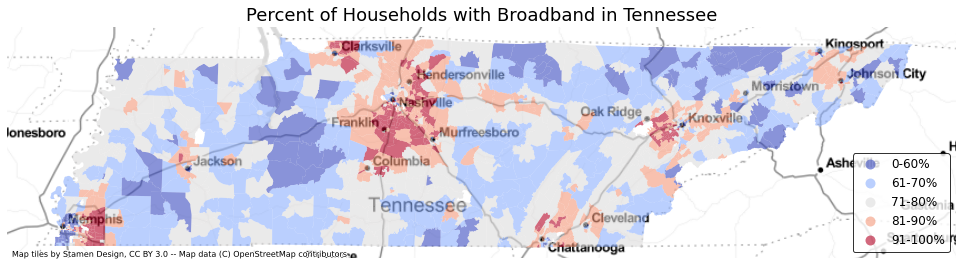

In [9]:
#create map of statewide broadband
import contextily as cx

cleaned=cleaned.to_crs(epsg=3857)

bins=[60,70,80,90,100]
bin_labels=['0-60%','61-70%','71-80%','81-90%','91-100%']

f,ax=plt.subplots(1,figsize=(17,8))
cleaned.plot(column='Pct_Broadband',scheme='User_Defined',ax=ax,classification_kwds={'bins':bins},
             legend=True,legend_kwds={'loc':'lower right','edgecolor':'k','labels':bin_labels,'fontsize':12},
             edgecolor='none',cmap='coolwarm',alpha=0.6)
cx.add_basemap(ax, crs=cleaned.crs.to_string(), source=cx.providers.Stamen.TonerLite,zoom=7)
ax.set_axis_off()
ax.set_title('Percent of Households with Broadband in Tennessee',fontsize=18)
plt.savefig('TN_Broadband.jpg',bbox_inches='tight',pad_inches=0)
plt.show()

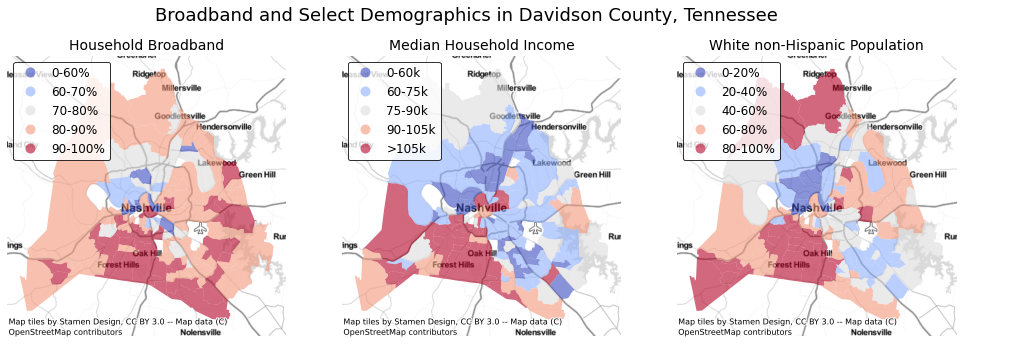

In [10]:
#create maps in Davidson County: broadband, income, percent white non-Hispanic population

davidson=cleaned[cleaned['GEOID'].str.match('^47037')]

def subplot_map(axes,gdf,col,bins,bin_labels,subtitle):
    gdf.plot(column=col,scheme='User_Defined',ax=axes,classification_kwds={'bins':bins},
                 legend=True,legend_kwds={'loc':'upper left','edgecolor':'k','labels':bin_labels,'fontsize':12},
                 edgecolor='none',cmap='coolwarm',alpha=0.6)
    cx.add_basemap(axes, crs=cleaned.crs.to_string(), source=cx.providers.Stamen.TonerLite,zoom=10)
    axes.set_axis_off()
    axes.set_title(subtitle,fontsize=14)
    return

f,ax=plt.subplots(1,3,figsize=(17,5.5))

bins=[60,70,80,90,100]
bin_labels=['0-60%','60-70%','70-80%','80-90%','90-100%']
subplot_map(ax[0],davidson,'Pct_Broadband',bins,bin_labels,'Household Broadband')

bins=[60000,75000,90000,105000,np.max(davidson['Median_Household_Income'])]
bin_labels=['0-60k','60-75k','75-90k','90-105k','>105k']
subplot_map(ax[1],davidson,'Median_Household_Income',bins,bin_labels,'Median Household Income')

bins=[20,40,60,80,100]
bin_labels=['0-20%','20-40%','40-60%','60-80%','80-100%']
subplot_map(ax[2],davidson,'Pct_White-Non-Hispanic',bins,bin_labels,'White non-Hispanic Population')

f.suptitle('Broadband and Select Demographics in Davidson County, Tennessee',fontsize=18)
plt.savefig('Davidson_factors.jpg',bbox_inches='tight',pad_inches=0)
plt.show()

In [11]:
#function to create polynomial regression for given variables
#outputs linear regression model and polynomial factors
#prints statistically significant factors and train/test r-squared

def polynomial_regression(X,y,degree=2,test_fraction=0.2,alpha=0.05):
    #set seed for reproducible results
    seed=0

    #transform variables for polynomial regression
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree)
    X_poly=poly.fit_transform(X)

    #split train and test data
    from sklearn.model_selection import train_test_split
    X_poly_train,X_poly_test,y_train,y_test=train_test_split(X_poly,y,random_state=seed,test_size=test_fraction)

    #scale factors
    from sklearn.preprocessing import StandardScaler
    scaler_poly=StandardScaler()
    X_poly_train_scaled=scaler_poly.fit_transform(X_poly_train)
    X_poly_test_scaled=scaler_poly.transform(X_poly_test)

    #create linear model
    from statsmodels.regression import linear_model
    import statsmodels.api as sm
    lin_poly=linear_model.OLS(y_train,sm.add_constant(X_poly_train_scaled)).fit()

    #apply Bonferroni correction to adjust 0.05 significance threshold to combat problem of multiple comparisons
    thresh=alpha/len(poly.get_feature_names(X.columns))
    print('Significance threshold p < {:.5f}'.format(thresh))
    print('\n')

    #print those factors with statistically significant coefficients
    print('Significant factors:')
    for l in sorted(list(zip(list(poly.get_feature_names(X.columns)),lin_poly.params,lin_poly.pvalues)),key=lambda x: x[2]):
        if l[2]<thresh:
            print('{}, coef={:.2f}, p={:.5f}'.format(l[0],l[1],l[2]))

    #print r-squared for train and test data
    from scipy.stats import pearsonr
    print('\n')
    print('Train r-squared = {:.2f}'.format(lin_poly.rsquared))
    print('Test r-squared = {:.2f}'.format(pearsonr(y_test,lin_poly.predict(sm.add_constant(X_poly_test_scaled)))[0]**2))
    print('\n')
    
    return lin_poly,X_poly_train,X_poly_test,y_train,y_test

In [12]:
#Polynomial regression of household broadband access using only population density, median household income, and median home value

#Gather variables for model
columns=['Pop_Density','Median_Household_Income','Median_Home_Value']

df=cleaned[columns+['GEOID','Pct_Broadband']]
df=df.set_index('GEOID')

X=df[columns]
y=df['Pct_Broadband']

reg,_,_,_,_=polynomial_regression(X,y)



Significance threshold p < 0.00500


Significant factors:
1, coef=75.78, p=0.00000
Median_Home_Value, coef=23.69, p=0.00000
Median_Household_Income Median_Home_Value, coef=-16.48, p=0.00000
Pop_Density^2, coef=7.16, p=0.00000


Train r-squared = 0.60
Test r-squared = 0.58




In [13]:
#Polynomial regression of household broadband access adding racial and ethnic information

#Gather variables for model
columns=['Pop_Density','Median_Household_Income','Median_Home_Value',
            'Pct_White-Non-Hispanic','Pct_Black-Non-Hispanic','Pct_Am_Ind-Non-Hispanic','Pct_Asian-Non-Hispanic',
            'Pct_Pac_Isl-Non-Hispanic','Pct_Other-Non-Hispanic','Pct_Two+Races-Non-Hispanic','Pct_Hispanic',]

df=cleaned[columns+['GEOID','Pct_Broadband']]
df=df.set_index('GEOID')

X=df[columns]
y=df['Pct_Broadband']

reg,_,_,_,_=polynomial_regression(X,y)


Significance threshold p < 0.00064


Significant factors:
1, coef=75.78, p=0.00000
Median_Home_Value, coef=12.39, p=0.00000
Median_Household_Income Pct_Black-Non-Hispanic, coef=9.59, p=0.00000
Pct_Am_Ind-Non-Hispanic^2, coef=3.10, p=0.00000
Pct_Black-Non-Hispanic Pct_Am_Ind-Non-Hispanic, coef=-1.83, p=0.00000
Pct_Am_Ind-Non-Hispanic, coef=-1.50, p=0.00000
Median_Household_Income Pct_Am_Ind-Non-Hispanic, coef=5.39, p=0.00000
Pop_Density Pct_Black-Non-Hispanic, coef=3.02, p=0.00000
Pct_Black-Non-Hispanic, coef=1.16, p=0.00000
Pct_White-Non-Hispanic Pct_Black-Non-Hispanic, coef=1.06, p=0.00000
Median_Household_Income Median_Home_Value, coef=-14.39, p=0.00004
Median_Household_Income, coef=1.70, p=0.00011
Median_Home_Value Pct_Am_Ind-Non-Hispanic, coef=2.68, p=0.00012
Pct_Hispanic, coef=1.32, p=0.00037
Pop_Density Pct_White-Non-Hispanic, coef=-3.69, p=0.00061


Train r-squared = 0.70
Test r-squared = 0.62




In [14]:
#increase plot font size
plt.rc('font',size=15)

#function to format plot axis style
def plot_style(ax):
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.tick_params(axis='x', color='grey', labelcolor='dimgrey')
    ax.tick_params(axis='y', color='grey', labelcolor='dimgrey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

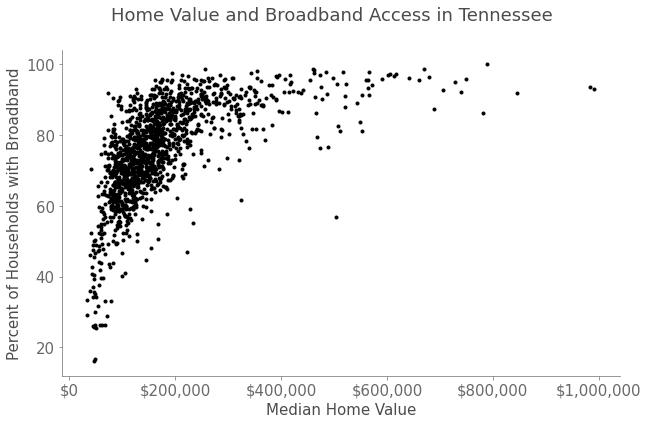

In [15]:
#plot relationship of strongest predictor: median home value
f,ax=plt.subplots(1,figsize=(10,6))
plt.scatter(X['Median_Home_Value'],y,marker='.',color='k');

#edit axes
plot_style(ax)
import matplotlib.ticker as tkr
ax.get_xaxis().set_major_formatter(tkr.StrMethodFormatter('${x:,.0f}'))

#labels
ax.set_xlabel('Median Home Value',alpha=0.7)
ax.set_ylabel('Percent of Households with Broadband',alpha=0.7)

f.suptitle('Home Value and Broadband Access in Tennessee',fontsize=18, alpha=0.7)
plt.savefig('Home_value_broadband.jpg',bbox_inches='tight',pad_inches=0)
plt.show()

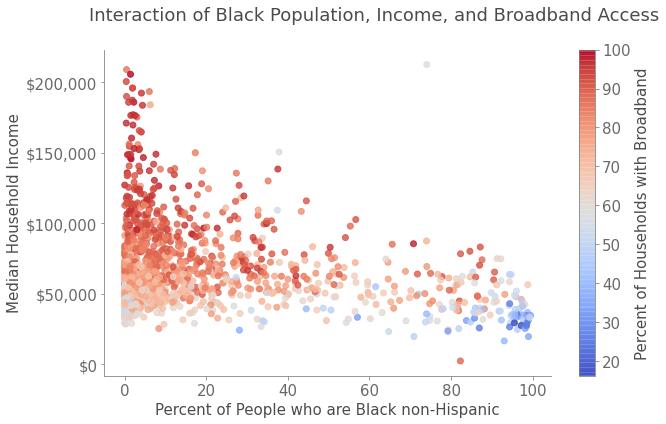

In [16]:
#make interaction plot of second-strongest predictor: interaction of Median_Household_Income and Pct_Black-Non-Hispanic
plotvars=['Pct_Black-Non-Hispanic','Median_Household_Income']
f,ax=plt.subplots(1,figsize=(10,6))
plt.scatter(X[plotvars[0]],X[plotvars[1]],c=y,cmap='coolwarm',alpha=0.8);
c=plt.colorbar();

#edit axes
plot_style(ax)
c.ax.tick_params(axis='y', color='grey', labelcolor='dimgrey')
c.outline.set_edgecolor('grey')
import matplotlib.ticker as tkr
ax.get_yaxis().set_major_formatter(tkr.StrMethodFormatter('${x:,.0f}'))

#labels
ax.set_xlabel('Percent of People who are Black non-Hispanic',alpha=0.7)
ax.set_ylabel('Median Household Income',alpha=0.7)
c.set_label('Percent of Households with Broadband', alpha=0.7)

f.suptitle('Interaction of Black Population, Income, and Broadband Access',fontsize=18,alpha=0.7)
plt.savefig('Black_Income_Broadband.jpg',bbox_inches='tight',pad_inches=0)
plt.show()

In [17]:
#use API to get median household income overall in TN
variables={'B25099_001E':'Median_Household_Income'}
var_types={x:'int64' for x in variables.values()}

location='&for=state:47'

state_val=call_API('2019','acs/acs5',variables,location,var_types)

TN_median_household_income=state_val.Median_Household_Income[0]

In [18]:
#examine trends within group below state median
lower_incomes=cleaned[cleaned['Median_Household_Income']<TN_median_household_income]

Low_Black_Broadband=lower_incomes[lower_incomes['Pct_Black-Non-Hispanic']<50]['Pct_Broadband']
High_Black_Broadband=lower_incomes[lower_incomes['Pct_Black-Non-Hispanic']>=50]['Pct_Broadband']

#calculate percent of tracts in each group with low household broadband
LB_Pct=len(Low_Black_Broadband[Low_Black_Broadband>=60])/len(Low_Black_Broadband)
HB_Pct=len(High_Black_Broadband[High_Black_Broadband>=60])/len(High_Black_Broadband)
print('Minority Black non-Hispanic lower-income tracts where 60% or more households have broadband: {:.0f}%'.format(LB_Pct*100))
print('Majority Black non-Hispanic lower-income tracts where 60% or more households have broadband: {:.0f}%'.format(HB_Pct*100))
print('Note "lower-income" tracts have median household incomes below the TN state median of ${:,}.'.format(TN_median_household_income))

Minority Black non-Hispanic lower-income tracts where 60% or more households have broadband: 90%
Majority Black non-Hispanic lower-income tracts where 60% or more households have broadband: 49%
Note "lower-income" tracts have median household incomes below the TN state median of $66,348.
